In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class DualAgentMaze:
    def __init__(self, maze_size=(10, 10), start_nodes=None, goal_nodes=None):
        self.maze_size = maze_size
        self.width = int(self.maze_size[0])
        self.height = int(self.maze_size[1])
        self.maze_map = np.zeros((self.height, self.width), dtype='int')

        # Đặt các điểm bắt đầu cho hai tác nhân
        if start_nodes is None:
            self.start_nodes = [(0, 0), (0, self.width - 1)]  # Hai tác nhân ở hai góc trên
        else:
            self.start_nodes = start_nodes

        # Đặt các điểm mục tiêu (phần thưởng) ở vị trí khác nhau
        if goal_nodes is None:
            self.goal_nodes = [(self.height - 1, 0), (self.height - 1, self.width - 1)]  # Hai phần thưởng ở hai góc dưới
        else:
            self.goal_nodes = goal_nodes

        # Đặt tường cố định để tạo ra mê cung
        self.add_fixed_walls()

    def add_fixed_walls(self):
        """ Thêm các tường cố định vào mê cung để tạo ra độ khó cao hơn và loại bỏ tường cụ thể """
        # Tường được thêm vào để tạo ra các lối đi hẹp và hành lang
        walls = [
            # Tạo các bức tường để tạo thành lối đi
            (1, 1), (1, 2), (1, 4), (1, 5), (1, 7),
            (2, 3), (2, 7), (2, 8),
            (3, 1), (3, 5), (3, 6), (3, 8),
            (4, 0), (4, 3), (4, 7), (4, 9),
            (5, 2), (5, 5), (5, 6),
            (6, 1), (6, 4), (6, 8),
            (7, 3), (7, 7),
            (8, 2), (8, 6), (8, 9)
        ]

        # Loại bỏ tường cụ thể mà bạn yêu cầu
        walls_to_remove = [(6, 4)]  # Bức tường tại vị trí này sẽ được loại bỏ
        walls = [wall for wall in walls if wall not in walls_to_remove]

        for (i, j) in walls:
            self.maze_map[i, j] = 1  # Đánh dấu tường là 1

    def plot_maze(self, agents_positions=None, show=True):
        # Tạo bản sao của `maze_map` để không thay đổi bản gốc
        temp_maze_map = np.copy(self.maze_map)

        # Đặt các tác nhân tại vị trí hiện tại của chúng
        if agents_positions:
            for idx, pos in enumerate(agents_positions):
                i, j = pos
                temp_maze_map[i, j] = 2 + idx  # Đặt màu xanh dương cho Agent A và màu xanh lá cho Agent B

        # Đặt điểm mục tiêu
        for (i, j) in self.goal_nodes:
            temp_maze_map[i, j] = 4  # Đánh dấu mục tiêu chung là 4 (màu vàng)

        # Tạo màu sắc cho từng giá trị trong bản đồ mê cung
        color_map = {
            0: 'white',     # Đường đi
            1: 'black',     # Tường
            2: 'blue',      # Vị trí hiện tại của tác nhân A
            3: 'green',     # Vị trí hiện tại của tác nhân B
            4: 'yellow',    # Phần thưởng chung cho cả hai tác nhân
        }

        # Chuẩn bị bản đồ màu cho `matplotlib`
        img = np.zeros((temp_maze_map.shape[0], temp_maze_map.shape[1], 3))
        for (i, j), value in np.ndenumerate(temp_maze_map):
            img[i, j] = colors.to_rgb(color_map[value])

        # Hiển thị mê cung với kích thước vừa phải và tường sát với tác nhân
        plt.figure(figsize=(8, 8))
        plt.imshow(img, origin='lower')

        plt.xticks([])
        plt.yticks([])
        plt.grid(visible=False)  # Tắt lưới để chỉ tập trung vào các thành phần của mê cung

        if show:
            plt.show()

In [59]:
# Lớp SARSAAgent sử dụng SARSA và thuật toán hợp tác
class SARSAAgent:
    def __init__(self, name, start_position, goal_position, actions, agent_number, shared_q_table,
                 gamma=0.9, learning_rate=0.1, exploration_rate=0.1, exploration_decay=0.995, delta=0.1):
        self.name = name
        self.start_position = start_position
        self.position = start_position
        self.goal = goal_position
        self.actions = actions  # Các hành động có thể: lên, xuống, trái, phải
        self.gamma = gamma  # Hệ số chiết khấu γ
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate  # Epsilon cho chính sách epsilon-greedy
        self.exploration_decay = exploration_decay  # Tỷ lệ giảm epsilon
        self.delta = delta  # Số δ (>0)
        self.q_table = shared_q_table  # Sử dụng bảng Q chung
        self.total_steps = 0
        self.agent_number = agent_number  # Số lượng tác nhân

        # Khởi tạo MaxStep và sử dụng trong defaultdict
        self.MaxStep = 1000
        self.tix = defaultdict(lambda: self.MaxStep)  # Lưu trữ tix_i cho mỗi mục tiêu x
        self.Tix = defaultdict(lambda: self.MaxStep)  # Lưu trữ Tix cho mỗi mục tiêu x
        self.internal_reward = 0  # Phần thưởng nội bộ

        # Khởi tạo tix và Tix cho mục tiêu riêng của tác nhân
        self.tix[self.goal] = self.MaxStep
        self.Tix[self.goal] = self.MaxStep

    def reset(self):
        """Khởi tạo lại trạng thái của tác nhân."""
        self.position = self.start_position
        self.total_steps = 0
        self.internal_reward = 0

    def choose_action(self, possible_actions):
        """Chọn một hành động dựa trên chính sách epsilon-greedy."""
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(possible_actions)
        else:
            q_values = [self.q_table[(self.position, action)] for action in possible_actions]
            max_q = max(q_values)
            max_actions = [action for action, q in zip(possible_actions, q_values) if q == max_q]
            return random.choice(max_actions)

    def update_q_value(self, state, action, reward, next_state, next_action):
        """Cập nhật giá trị Q dựa trên SARSA (State-Action-Reward-State-Action)."""
        total_reward = reward + self.internal_reward
        current_q = self.q_table[(state, action)]
        next_q = self.q_table[(next_state, next_action)]
        new_q = current_q + self.learning_rate * (total_reward + self.gamma * next_q - current_q)
        self.q_table[(state, action)] = new_q

    def decay_exploration(self):
        """Giảm tỷ lệ khám phá."""
        self.exploration_rate *= self.exploration_decay

    def estimate_internal_reward(self):
        """Tính toán phần thưởng nội bộ dựa trên công thức."""
        tAL = self.tix[self.goal]
        tAS = self.Tix[self.goal]
        gamma = self.gamma
        delta = self.delta
        if tAL - tAS > 0:
            ir = (gamma ** (tAL - tAS)) * self.internal_reward + delta
        else:
            ir = self.internal_reward
        self.internal_reward = ir

    def share_tix(self, agents):
        """Chia sẻ tix_i với các tác nhân khác."""
        for agent in agents:
            if agent != self:
                if self.goal in agent.tix:
                    agent.tix[self.goal] = min(agent.tix[self.goal], self.tix[self.goal])





Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -10964.6   |
| Agent B |   -16345.0   |
+---------+--------------+
Số bước trung bình mỗi tập: 468.32
Tổng thời gian huấn luyện: 3.9239 giây
--------------------------------------------------------------------------------
Tập 502/1000 - Tổng phần thưởng:
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -10965.4   |
| Agent B |   -16347.0   |
+---------+--------------+
Số bước trung bình mỗi tập: 467.45
Tổng thời gian huấn luyện: 3.9246 giây
--------------------------------------------------------------------------------
Tập 503/1000 - Tổng phần thưởng:
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -10965.6   |
| Agent B |   -16447.0   |
+---------+--------------+
Số bước trung bình mỗi tập: 468.50
Tổng thời gian huấn luyện: 3.9387 giây
-------

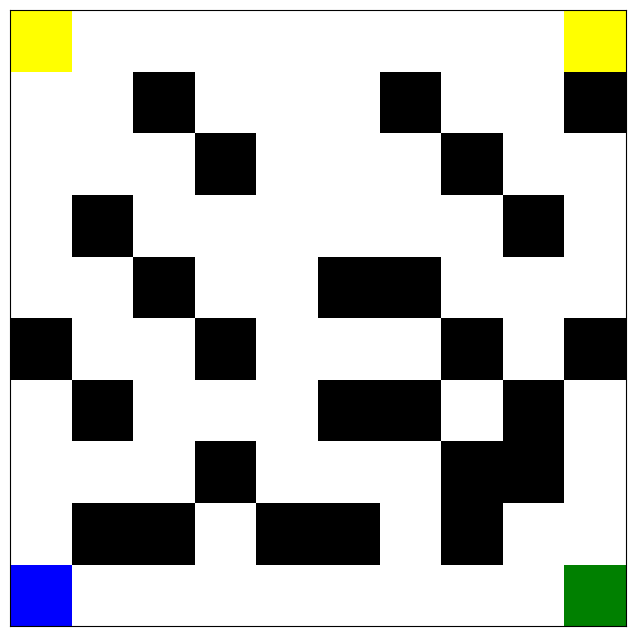

Agent A moved to (1, 0), Reward: -0.1, Total steps: 1
Agent B moved to (0, 8), Reward: -0.1, Total steps: 1


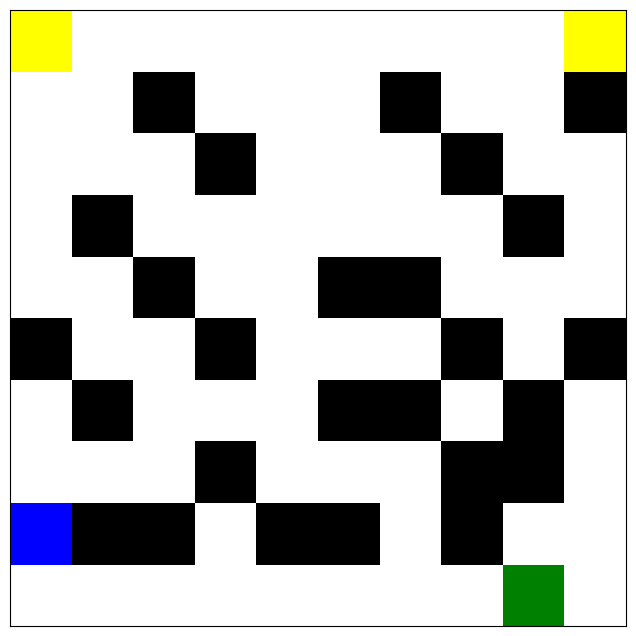

Agent A moved to (2, 0), Reward: -0.1, Total steps: 2
Agent B moved to (0, 7), Reward: -0.1, Total steps: 2


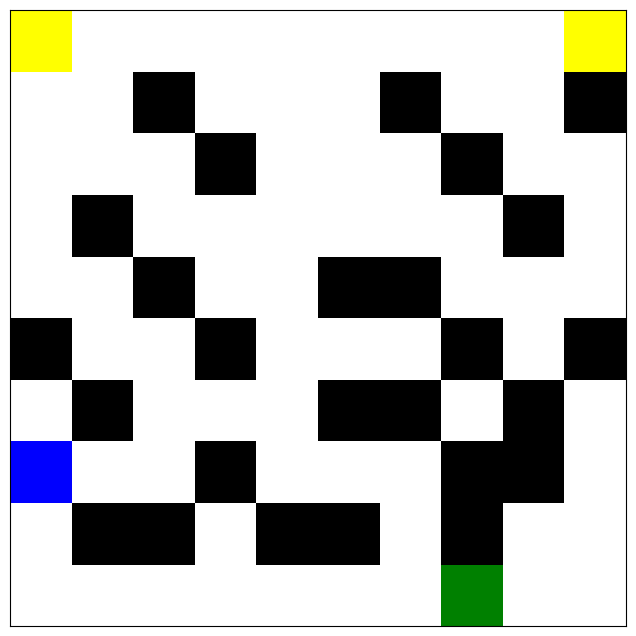

Agent A moved to (2, 1), Reward: -0.1, Total steps: 3
Agent B moved to (0, 6), Reward: -0.1, Total steps: 3


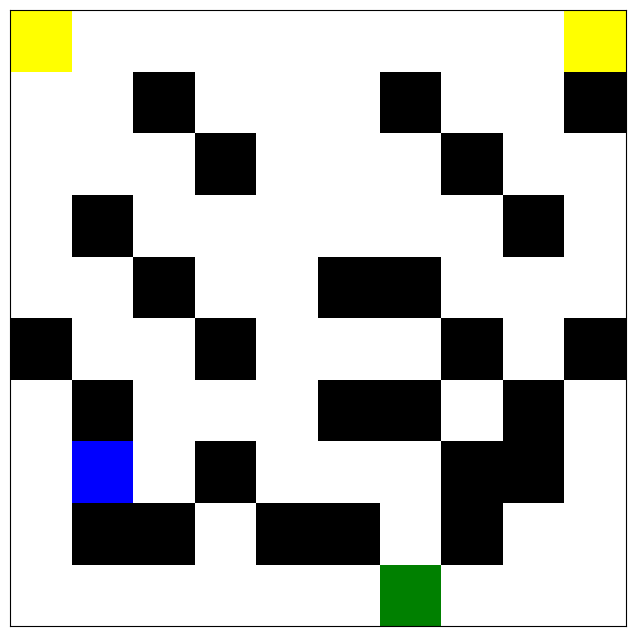

Agent A moved to (2, 2), Reward: -0.1, Total steps: 4
Agent B moved to (1, 6), Reward: -0.1, Total steps: 4


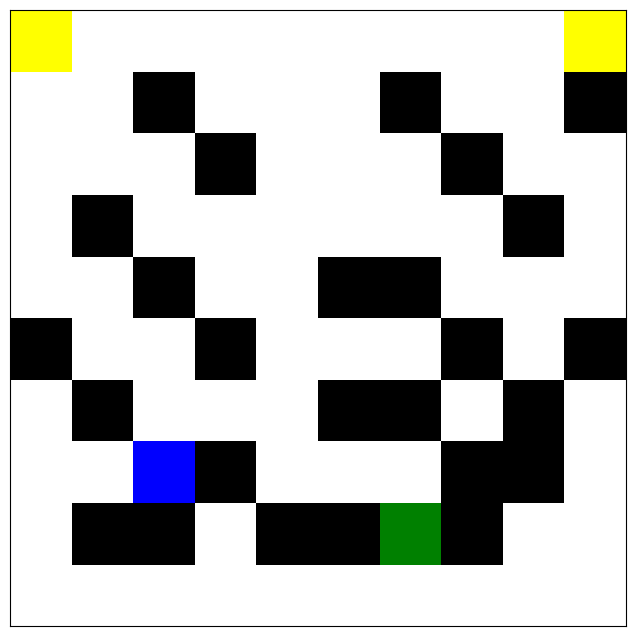

Agent A moved to (3, 2), Reward: -0.1, Total steps: 5
Agent B moved to (2, 6), Reward: -0.1, Total steps: 5


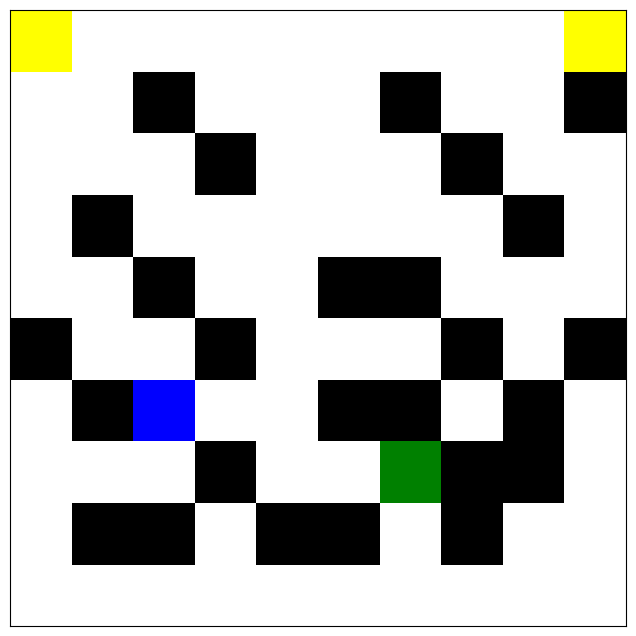

Agent A moved to (4, 2), Reward: -0.1, Total steps: 6
Agent B moved to (2, 5), Reward: -0.1, Total steps: 6


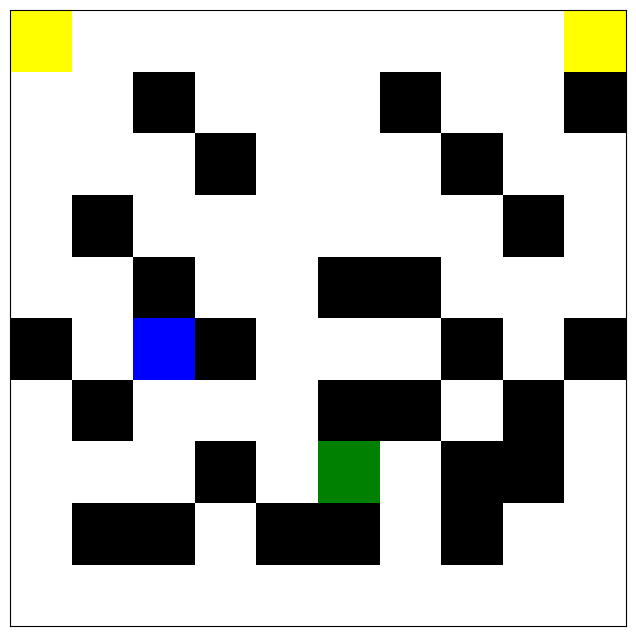

Agent A moved to (4, 1), Reward: -0.1, Total steps: 7
Agent B moved to (2, 4), Reward: -0.1, Total steps: 7


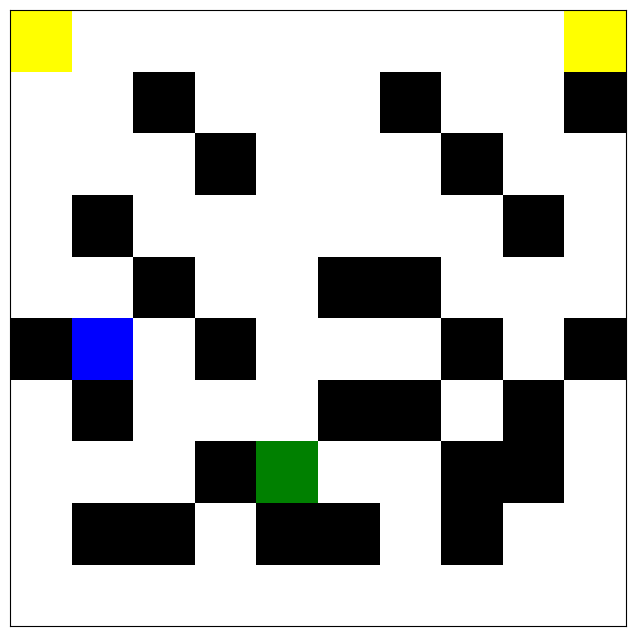

Agent A moved to (5, 1), Reward: -0.1, Total steps: 8
Agent B moved to (3, 4), Reward: -0.1, Total steps: 8


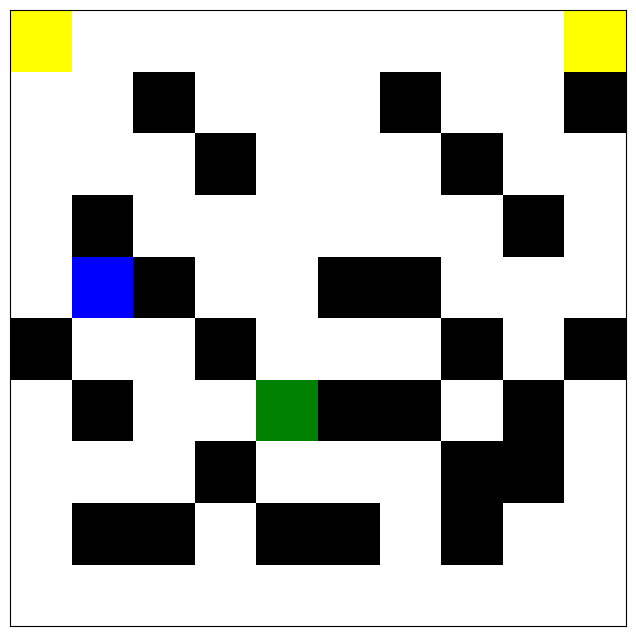

Agent A moved to (5, 0), Reward: -0.1, Total steps: 9
Agent B moved to (4, 4), Reward: -0.1, Total steps: 9


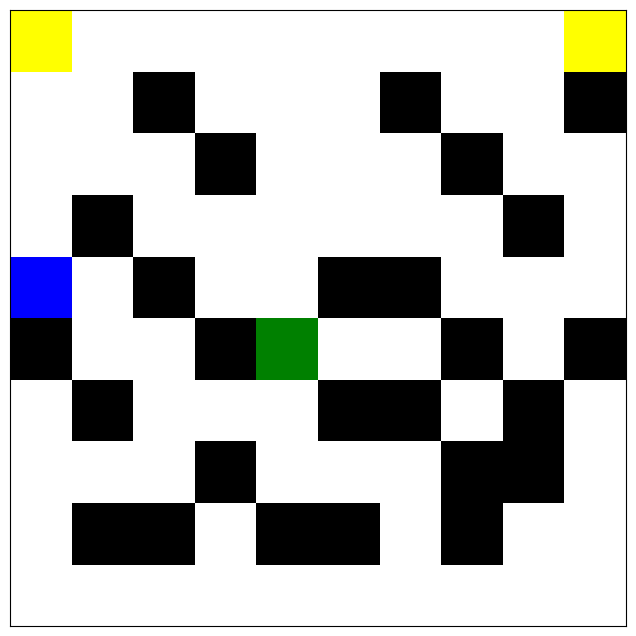

Agent A moved to (6, 0), Reward: -0.1, Total steps: 10
Agent B moved to (5, 4), Reward: -0.1, Total steps: 10


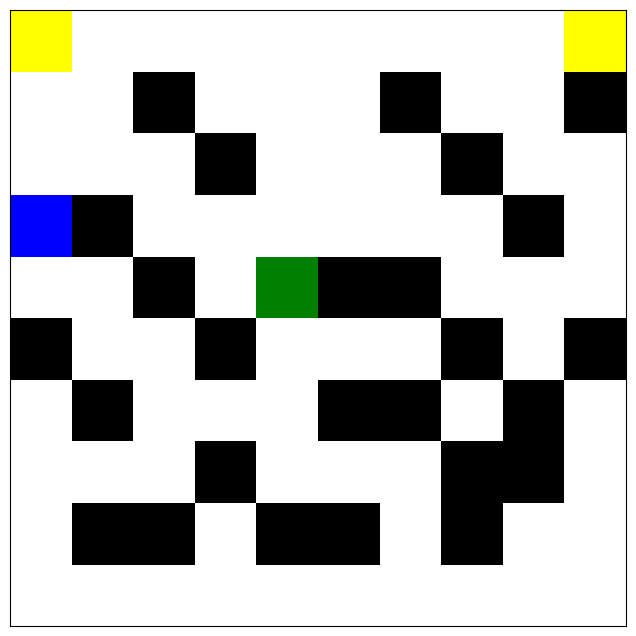

Agent A moved to (7, 0), Reward: -0.1, Total steps: 11
Agent B moved to (6, 4), Reward: -0.1, Total steps: 11


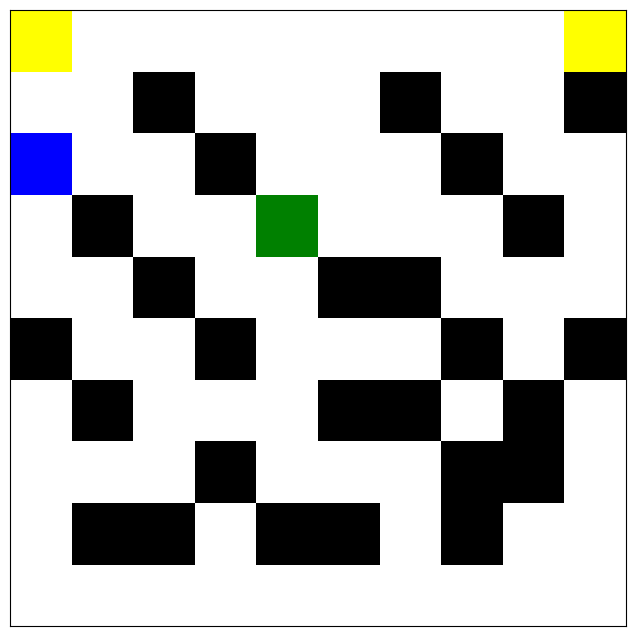

Agent A moved to (8, 0), Reward: -0.1, Total steps: 12
Agent B moved to (7, 4), Reward: -0.1, Total steps: 12


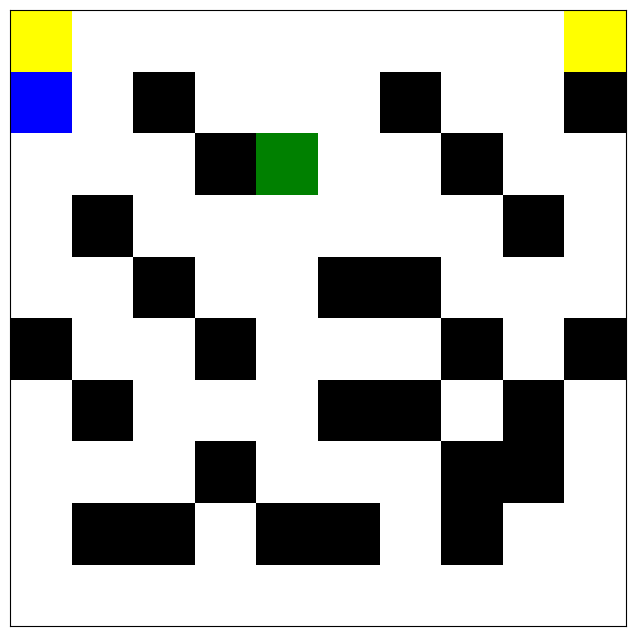

Agent A moved to (9, 0), Reward: 1, Total steps: 13
Agent B moved to (7, 5), Reward: -0.1, Total steps: 13


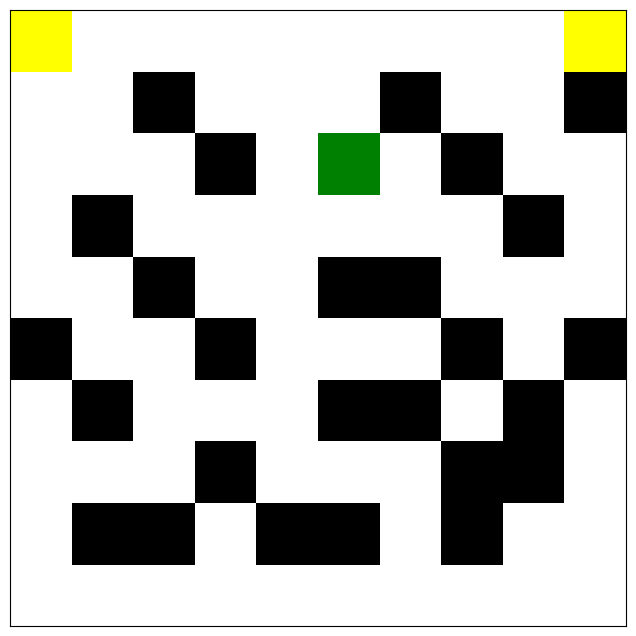

Agent B moved to (8, 5), Reward: -0.1, Total steps: 14


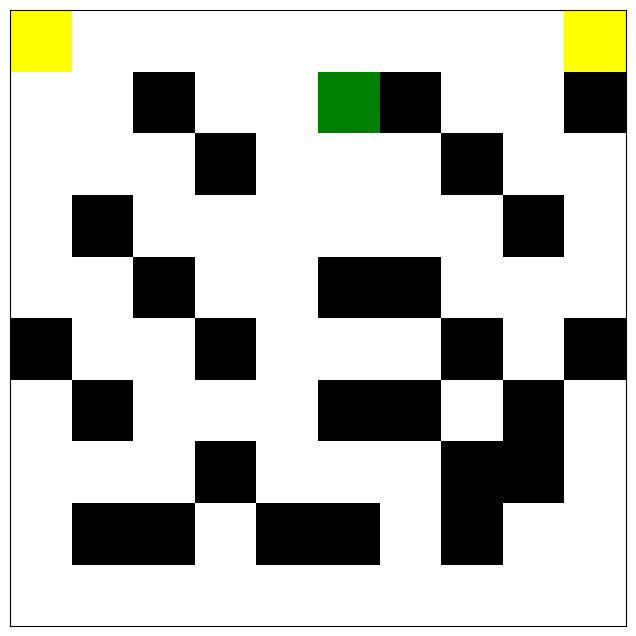

Agent B moved to (9, 5), Reward: -0.1, Total steps: 15


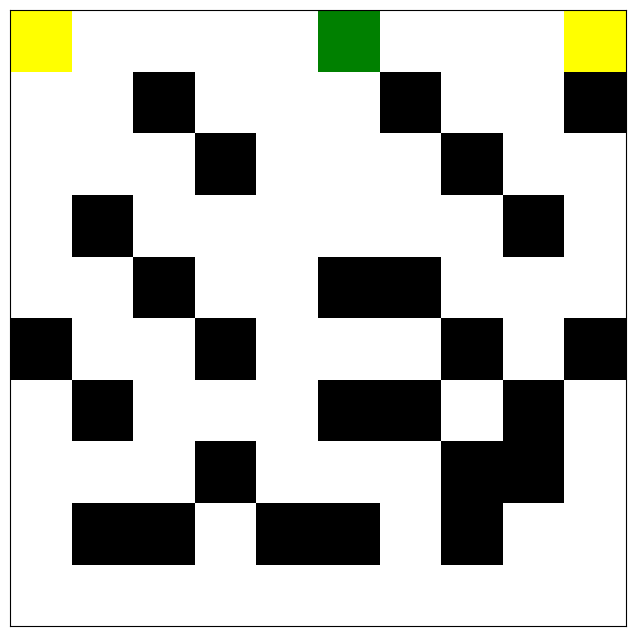

Agent B moved to (9, 6), Reward: -0.1, Total steps: 16


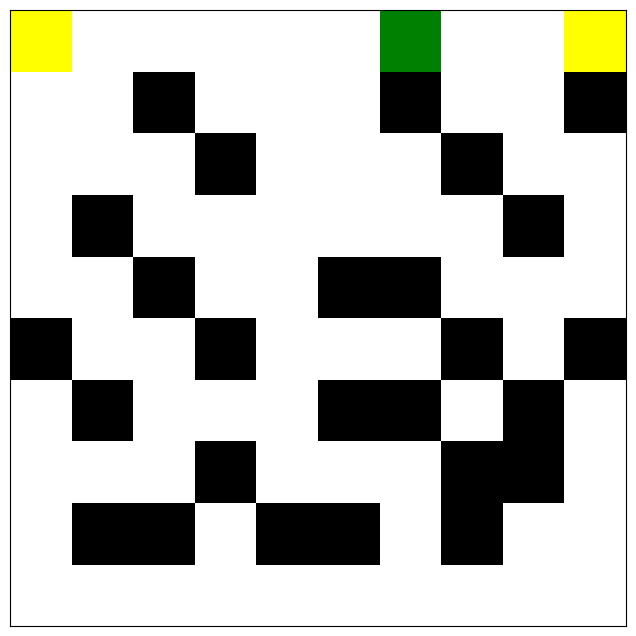

Agent B moved to (9, 7), Reward: -0.1, Total steps: 17


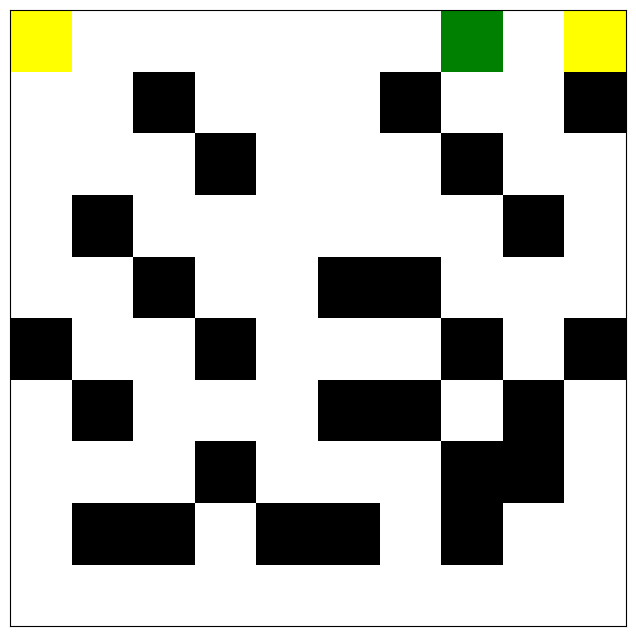

Agent B moved to (9, 8), Reward: -0.1, Total steps: 18


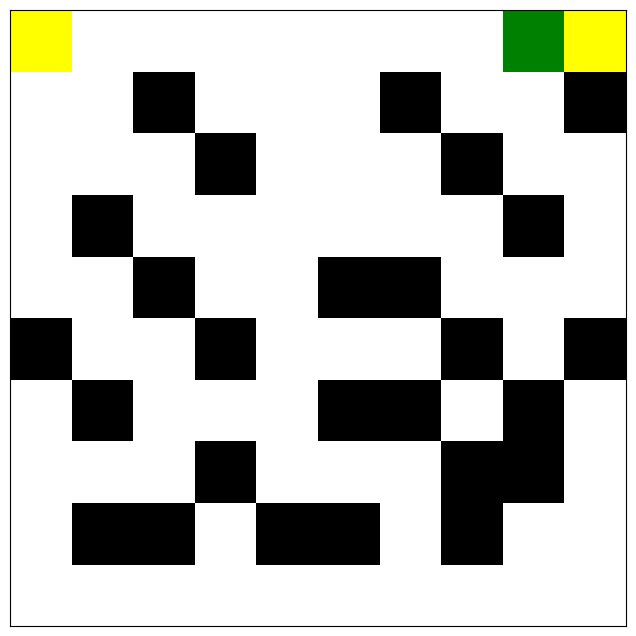

Agent B moved to (9, 9), Reward: 1, Total steps: 19


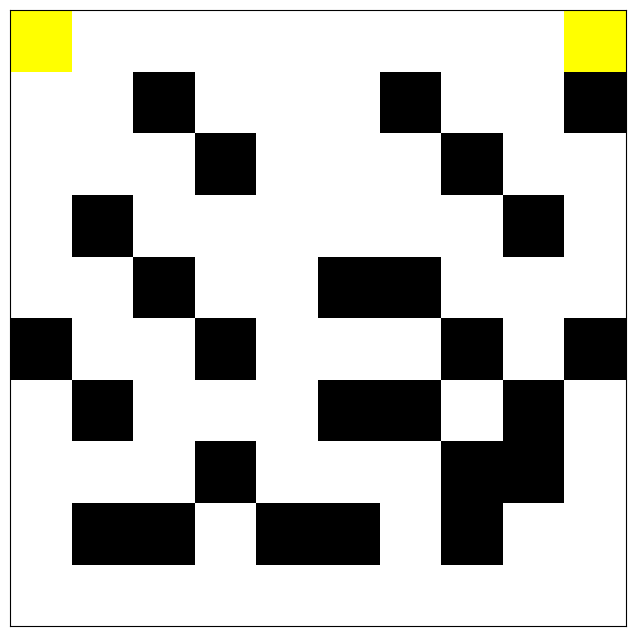

Agent A tổng phần thưởng: -0.19999999999999996, Tổng số bước: 13
Agent B tổng phần thưởng: -0.8000000000000005, Tổng số bước: 19


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import time
from tabulate import tabulate  # Import thư viện tabulate để in bảng

class MazeEnv:
    def __init__(self, maze):
        self.maze = maze
        # Các hành động: lên, xuống, trái, phải
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        # Tạo một bảng Q chung
        shared_q_table = defaultdict(float)
        # Khởi tạo hai tác nhân SARSA sử dụng bảng Q chung
        self.agent_A = SARSAAgent(
            "Agent A",
            maze.start_nodes[0],
            maze.goal_nodes[0],
            self.actions,
            agent_number=2,
            shared_q_table=shared_q_table
        )
        self.agent_B = SARSAAgent(
            "Agent B",
            maze.start_nodes[1],
            maze.goal_nodes[1],
            self.actions,
            agent_number=2,
            shared_q_table=shared_q_table
        )
        self.agents = [self.agent_A, self.agent_B]
        self.goals_reached = [False, False]

    def reset(self):
        for agent in self.agents:
            agent.reset()
        self.goals_reached = [False, False]
        return [agent.position for agent in self.agents]

    def step(self, agent_idx, action):
        agent = self.agents[agent_idx]
        possible_actions = self.get_possible_actions(agent)
        reward = -0.1  # Phạt cho mỗi bước đi

        if action in possible_actions:
            new_position = (agent.position[0] + action[0], agent.position[1] + action[1])
            agent.position = new_position
            agent.total_steps += 1
        else:
            reward = -1  # Phạt nặng cho hành động không hợp lệ

        done = False
        if agent.position == agent.goal and not self.goals_reached[agent_idx]:
            reward = 1  # Phần thưởng khi đến đích
            done = True
            self.goals_reached[agent_idx] = True

            # Cập nhật Tix
            agent.Tix[agent.goal] = agent.total_steps

        return agent.position, reward, done

    def get_possible_actions(self, agent):
        x, y = agent.position
        possible_actions = []
        for dx, dy in self.actions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze.height and 0 <= ny < self.maze.width:
                if self.maze.maze_map[nx, ny] != 1:  # Không phải tường
                    possible_actions.append((dx, dy))
        return possible_actions

    def render(self):
        """Hiển thị mê cung và vị trí của hai tác nhân"""
        agents_positions = [agent.position for agent in self.agents]
        self.maze.plot_maze(agents_positions=agents_positions)

# Hàm chạy các tác nhân đã được huấn luyện
def run_trained_agents(env):
    env.reset()
    done = [False, False]
    total_reward = {agent.name: 0 for agent in env.agents}

    while not all(done):
        env.render()  # In ra mê cung với trạng thái hiện tại của các tác nhân
        for idx, agent in enumerate(env.agents):
            if not done[idx]:
                state = agent.position
                possible_actions = env.get_possible_actions(agent)
                if not possible_actions:
                    continue  # Không có hành động khả thi
                # Chọn hành động tốt nhất dựa trên Q-values đã học
                q_values = [agent.q_table[(state, action)] for action in possible_actions]
                max_q = max(q_values)
                max_actions = [action for action, q in zip(possible_actions, q_values) if q == max_q]
                action = random.choice(max_actions)
                next_state, reward, done[idx] = env.step(idx, action)
                total_reward[agent.name] += reward
                print(f"{agent.name} moved to {next_state}, Reward: {reward}, Total steps: {agent.total_steps}")

    env.render()  # In ra mê cung khi kết thúc
    for agent in env.agents:
        print(f"{agent.name} tổng phần thưởng: {total_reward[agent.name]}, Tổng số bước: {agent.total_steps}")

# Hàm chính
if __name__ == "__main__":
    # Khởi tạo đối tượng `DualAgentMaze`
    maze = DualAgentMaze(maze_size=(10, 10))
    env = MazeEnv(maze)

    # Huấn luyện các tác nhân và thu thập lịch sử phần thưởng và thời gian
    rewards_history, total_time, steps_history = train_agents(
        env, episodes=1000, max_steps_per_episode=1000
    )

    # Chạy các tác nhân đã được huấn luyện
    run_trained_agents(env)


In [61]:
# Hàm huấn luyện các tác nhân với thuật toán SARSA và thu thập lịch sử phần thưởng
def train_agents(env, episodes=1000, max_steps_per_episode=1000):
    for agent in env.agents:
        agent.tix[agent.goal] = agent.MaxStep

    rewards_history = {agent.name: [] for agent in env.agents}  # Lưu lịch sử phần thưởng cho mỗi tập
    steps_history = []  # Lưu trữ số bước mỗi tập
    total_time = 0  # Tổng thời gian huấn luyện

    for episode in range(1, episodes + 1):
        env.reset()
        done = [False, False]
        steps = 0
        episode_rewards = {agent.name: 0 for agent in env.agents}

        start_time = time.time()  # Bắt đầu đếm thời gian cho tập này

        for agent in env.agents:
            agent.decay_exploration()  # Giảm tỷ lệ khám phá

        # Chọn hành động đầu tiên cho mỗi tác nhân
        actions = [agent.choose_action(env.get_possible_actions(agent)) for agent in env.agents]

        while not all(done) and steps < max_steps_per_episode:
            steps += 1
            for idx, agent in enumerate(env.agents):
                if not done[idx]:
                    state = agent.position
                    action = actions[idx]
                    next_state, reward, done[idx] = env.step(idx, action)
                    next_possible_actions = env.get_possible_actions(agent)

                    # Chọn hành động tiếp theo theo chính sách epsilon-greedy
                    next_action = agent.choose_action(next_possible_actions)

                    # Cập nhật giá trị Q bằng SARSA
                    agent.update_q_value(state, action, reward, next_state, next_action)

                    # Cập nhật hành động hiện tại thành hành động tiếp theo
                    actions[idx] = next_action

                    # Ghi nhận phần thưởng cho tập này
                    episode_rewards[agent.name] += reward

                    if done[idx]:
                        agent.Tix[agent.goal] = steps

            # Sau mỗi bước, các tác nhân chia sẻ tix_i
            for agent in env.agents:
                goal = agent.goal
                Tix = agent.Tix[goal]
                if Tix < agent.tix[goal]:
                    agent.tix[goal] = Tix
                    agent.share_tix(env.agents)

        end_time = time.time()  # Kết thúc đếm thời gian cho tập này
        elapsed_time = end_time - start_time  # Thời gian đã trôi qua cho tập này
        total_time += elapsed_time  # Cộng dồn tổng thời gian huấn luyện

        for agent in env.agents:
            agent.estimate_internal_reward()

        # Ghi nhận lịch sử phần thưởng cho mỗi tác nhân
        for agent in env.agents:
            rewards_history[agent.name].append(episode_rewards[agent.name])

        steps_history.append(steps)

        if episode > 0:
            print(f"Tập {episode}/{episodes} - Tổng phần thưởng:")
            table = []
            for agent in env.agents:
                total_reward = sum(rewards_history[agent.name])  # Tổng phần thưởng đến hiện tại
                table.append([agent.name, round(total_reward, 4)])
            print(tabulate(table, headers=["Agent", "Total Reward"], tablefmt="pretty"))
            print(f"Số bước trung bình mỗi tập: {np.mean(steps_history):.2f}")
            print(f"Tổng thời gian huấn luyện: {total_time:.4f} giây")
            print("-" * 80)

    print("Huấn luyện hoàn tất.")
    return rewards_history, total_time, steps_history


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -8019.8    |
| Agent B |   -11499.0   |
+---------+--------------+
Số bước trung bình mỗi tập: 328.26
Tổng thời gian huấn luyện: 3.5147 giây
--------------------------------------------------------------------------------
Tập 502/1000 - Tổng phần thưởng:
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -8020.2    |
| Agent B |   -11499.8   |
+---------+--------------+
Số bước trung bình mỗi tập: 327.65
Tổng thời gian huấn luyện: 3.5152 giây
--------------------------------------------------------------------------------
Tập 503/1000 - Tổng phần thưởng:
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -8020.6    |
| Agent B |   -11500.6   |
+---------+--------------+
Số bước trung bình mỗi tập: 327.03
Tổng thời gian huấn luyện: 3.5156 giây
-------

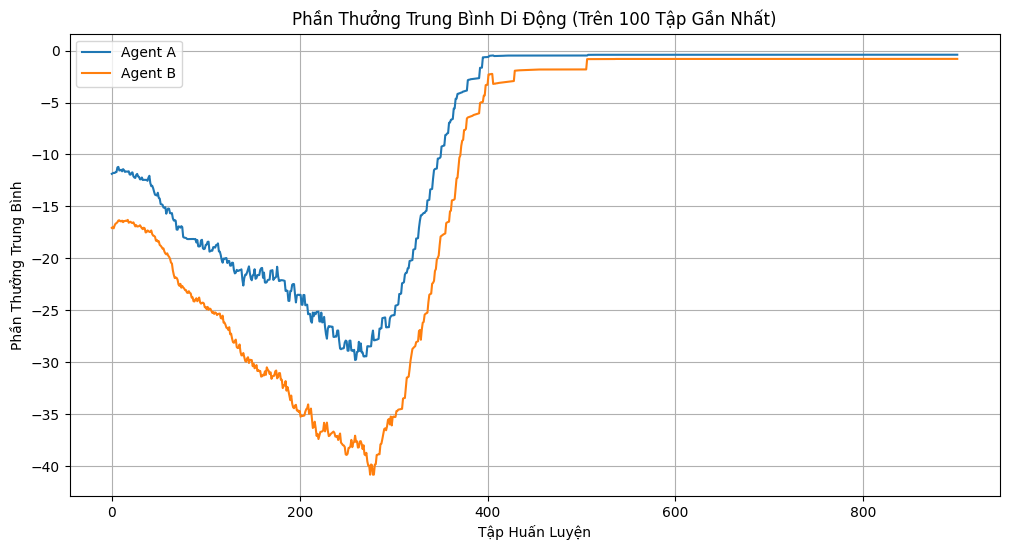

In [62]:
# Hàm để vẽ biểu đồ phần thưởng trung bình di động
def plot_moving_averages(rewards_history, window=100):
    plt.figure(figsize=(12, 6))

    for agent_name, rewards in rewards_history.items():
        # Tính phần thưởng trung bình di động (moving average)
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(moving_avg, label=agent_name)  # Vẽ biểu đồ cho mỗi tác nhân

    plt.xlabel('Tập Huấn Luyện')
    plt.ylabel('Phần Thưởng Trung Bình')
    plt.title(f'Phần Thưởng Trung Bình Di Động (Trên {window} Tập Gần Nhất)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Gọi hàm để vẽ biểu đồ phần thưởng trung bình di động sau khi huấn luyện
if __name__ == "__main__":
    # Khởi tạo đối tượng `DualAgentMaze`
    maze = DualAgentMaze(maze_size=(10, 10))
    env = MazeEnv(maze)

    # Huấn luyện các tác nhân và thu thập lịch sử phần thưởng và thời gian
    rewards_history, total_time, steps_history = train_agents(
        env, episodes=1000, max_steps_per_episode=1000
    )

    # Vẽ biểu đồ phần thưởng trung bình di động
    plot_moving_averages(rewards_history, window=100)


In [63]:
# Giả sử đã có đối tượng môi trường 'env' sau khi mô hình đã được huấn luyện
save_model(env, 'trained_modelsarsa.pkl')


Model saved to trained_model.pkl


In [64]:
!git --version


git version 2.34.1


In [65]:
!git clone https://github.com/ta01012004/mutilangent-for-maze.git

Cloning into 'mutilangent-for-maze'...


In [66]:
!cp https://github.com/ta01012004/mutilangent-for-maze.git /content/mutilangent-for-maze


cp: cannot stat 'https://github.com/ta01012004/mutilangent-for-maze.git': No such file or directory
